In [1]:
import funcs

import itertools
import numpy as np
from numba import jit
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [3]:
# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [4]:
band = '1A'
# filename = 'M105_00_000.fits' # CV3 F770W flat from Jane
# # CV3 MIRM33541
# if band in ['1A','2A']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits'
# elif band in ['1B','2B']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_495_SE_2016-01-19T10h33m18.fits'
# elif band in ['1C','2C']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_495_SE_2016-01-19T11h07m48.fits'
# elif band in ['3A','4A']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_494_SE_2016-01-19T09h59m18.fits'
# elif band in ['3B','4B']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_494_SE_2016-01-19T10h33m19.fits'
# elif band in ['3C','4C']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_494_SE_2016-01-19T11h07m48.fits'
# CV3 MIRM108 (ramps purposed for non-linearity correction)
if band in ['1A','2A']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits'
elif band in ['1B','2B']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_494_SE_2016-01-21T20h36m13.fits'
elif band in ['1C','2C']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_495_SE_2016-01-21T21h49m12.fits'
elif band in ['3A','4A']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_494_SE_2016-01-21T21h49m12.fits'
elif band in ['3B','4B']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_495_SE_2016-01-21T22h32m32.fits'
elif band in ['3C','4C']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_494_SE_2016-01-21T22h32m32.fits'
image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:]

In [5]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 6
Number of groups/frames per integration: 60
Total number of frames: 360
Time between samples: 2.77504 sec
LVL1 data shape: (360, 1024, 1032)


In [6]:
# initialize placeholders
out_parameters = np.zeros(shape =(order + 1, image_shape[1], image_shape[2] ), dtype=np.float64)
count_rate_at_0DN = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

print('Output parameters (object shape): {}'.format(out_parameters.shape))
print('Count rate at 0DN (object shape): {}'.format(count_rate_at_0DN.shape))

Output parameters (object shape): (5, 1024, 1032)
Count rate at 0DN (object shape): (1024, 1032)


## Derive non-linearity correction for a single pixel

<IPython.core.display.Javascript object>


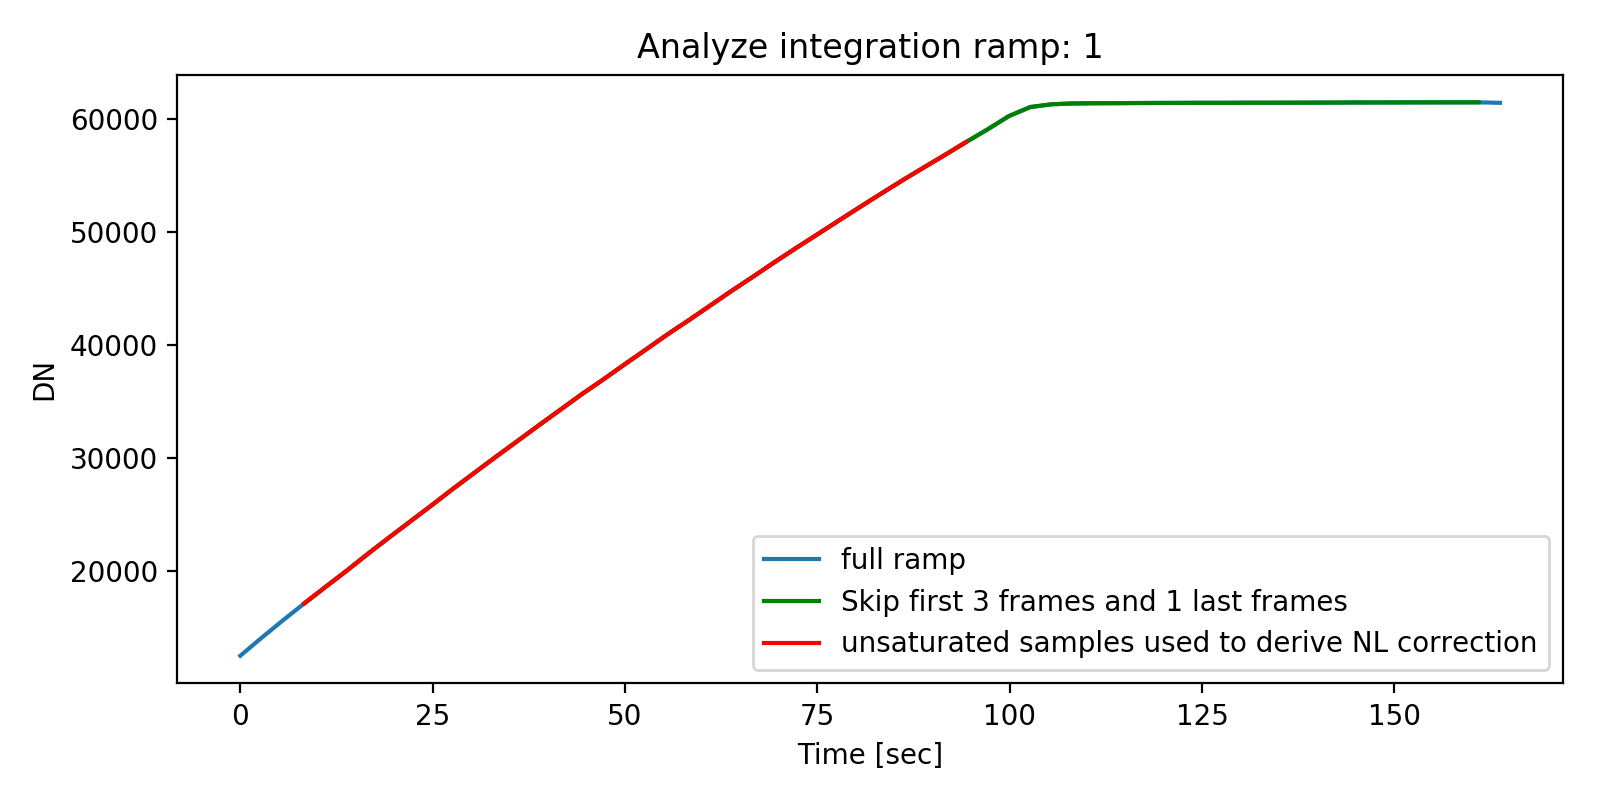

In [7]:
# Define ramp to be used for derivation of non-linearity correction
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
ypos,xpos = trace_y[512],trace_x[512]

time  = np.arange(nframes)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

plt.figure(figsize=(8,4))
plt.plot(time,tramp,label='full ramp')
plt.plot(time2,tramp2,'g',label='Skip first {} frames and {} last frames'.format(skip_first,skip_last))
plt.plot(time3,tramp3,'r',label='unsaturated samples used to derive NL correction')
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.legend(fontsize=10)
plt.title('Analyze integration ramp: {}'.format(analyze_ramp))
plt.tight_layout()

<IPython.core.display.Javascript object>


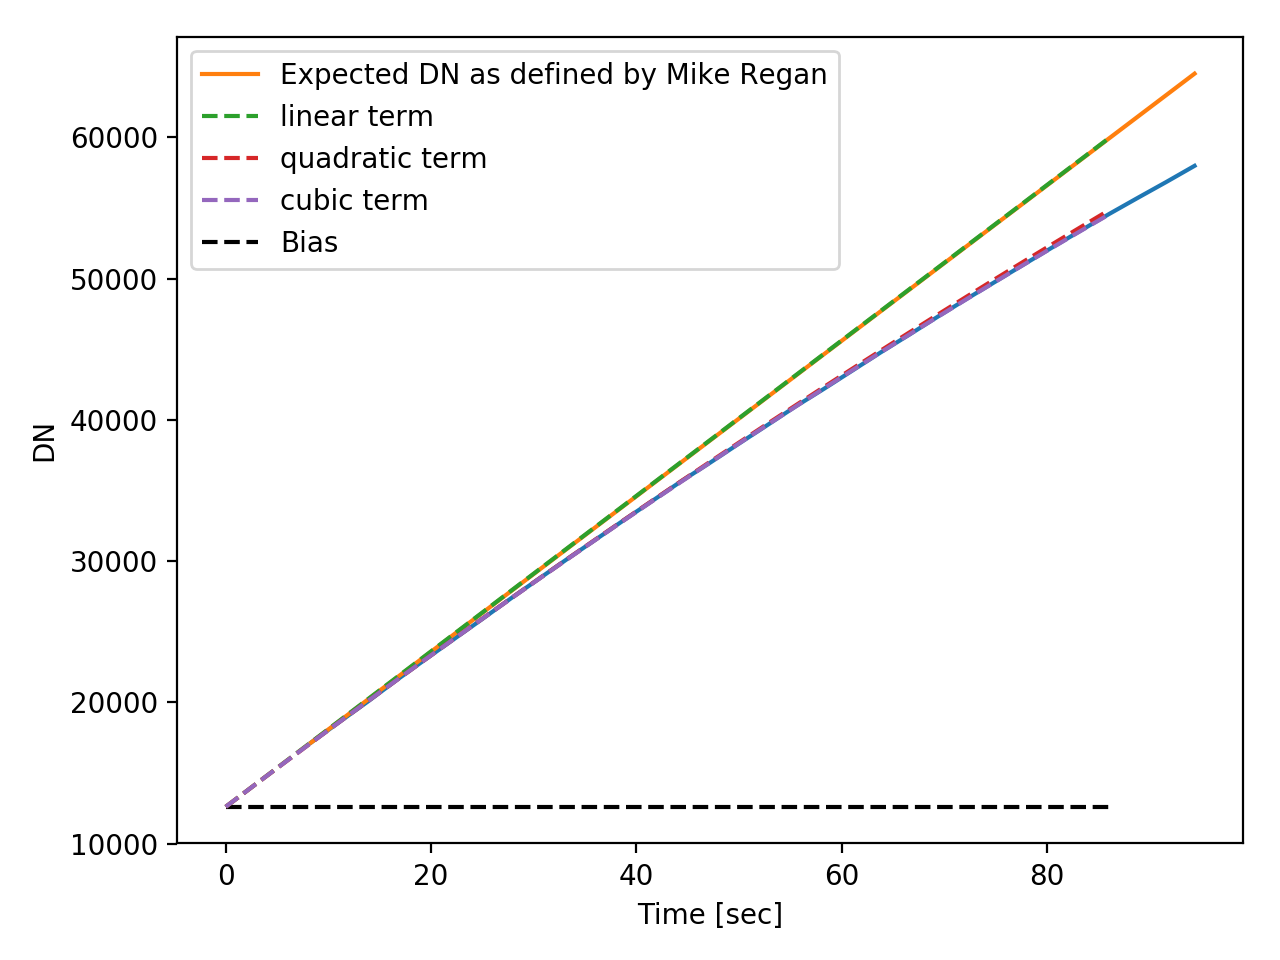

<IPython.core.display.Javascript object>


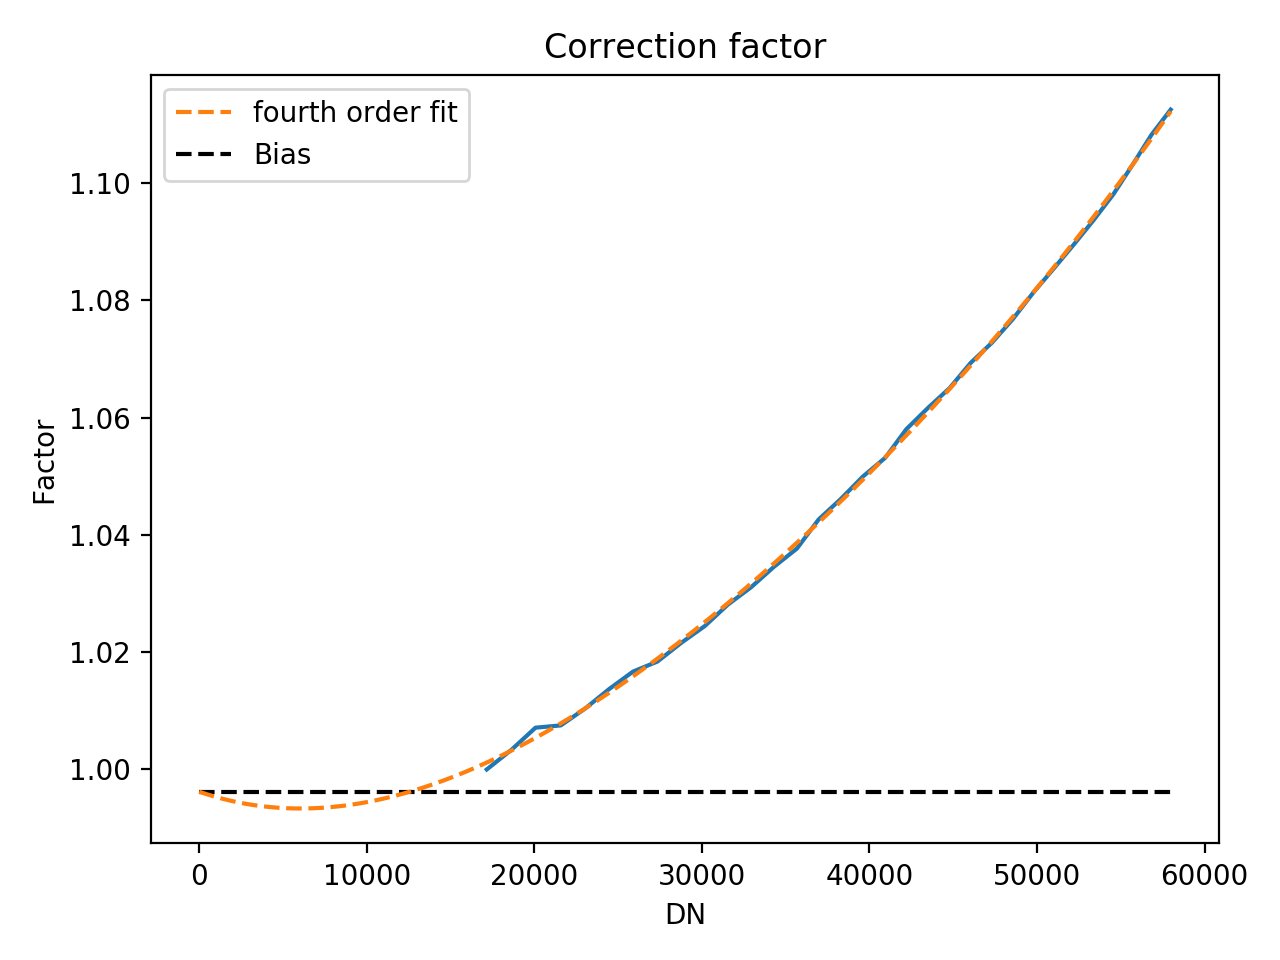

In [8]:
# derive non-linearity correction
intime = time3
inramp = tramp3

num_samples = inramp.size
first_fit_order = 3
assert num_samples > order + 3, 'Not enough samples to derive a non-linearity correction'

bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)

expected_rate = linear_term
expected_DN = expected_rate * (intime-intime[0]) + inramp[0]

time = np.arange(len(inramp))*frame_delta_time
plt.figure()
plt.plot(intime,inramp)
plt.plot(intime,expected_DN,label='Expected DN as defined by Mike Regan')
plt.hlines(bias,0,time[-1],'k',linestyle='dashed',label='Bias')
plt.plot(time,bias+linear_term*time,label='linear term',linestyle='dashed')
plt.plot(time,bias+linear_term*time+quad_term*time**2,label='quadratic term',linestyle='dashed')
plt.plot(time,bias+linear_term*time+quad_term*time**2+cubic_term*time**3,label='cubic term',linestyle='dashed')
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.legend()
plt.tight_layout()

# now get the ratio between the expected DN and the actual DN. 
# This is the correction factor.
correction_factor = expected_DN/inramp
assert np.sum(np.isfinite(correction_factor)) == correction_factor.size, 'There are non legal values in the correction factor array'

#solve for the correction factor as a function of observed DN.
coefs = np.polynomial.polynomial.polyfit(inramp, correction_factor, order)
poly = np.poly1d(coefs[::-1])

ramp = np.linspace(0,inramp[-1],1000)
plt.figure()
# plt.plot(ramp,poly(ramp))
plt.plot(inramp,correction_factor)
plt.hlines(coefs[0],0,inramp[-1],'k',linestyle='dashed',label='Bias')
plt.plot(ramp,coefs[0]+coefs[1]*ramp+coefs[2]*ramp**2+coefs[3]*ramp**3+coefs[4]*ramp**4,label='fourth order fit',linestyle='dashed')
plt.title('Correction factor')
plt.xlabel('DN')
plt.ylabel('Factor')
plt.legend()
plt.tight_layout()

In [11]:
# insert results in placeholder array
out_parameters[:, ypos,xpos] = coefs
count_rate_at_0DN[ypos,xpos] = expected_rate

In [12]:
# apply correction
# define placeholders
out_ramp = np.zeros_like(inramp, dtype=np.float64)
new_rate = np.zeros(shape=(len(inramp)-1, image_shape[1], image_shape[2]), dtype=np.float64)

print('Output ramp (object shape): {}'.format(out_ramp.shape))
print('New rate (object shape): {}'.format(new_rate.shape))

Output ramp (object shape): (32,)
New rate (object shape): (31, 1024, 1032)


<IPython.core.display.Javascript object>


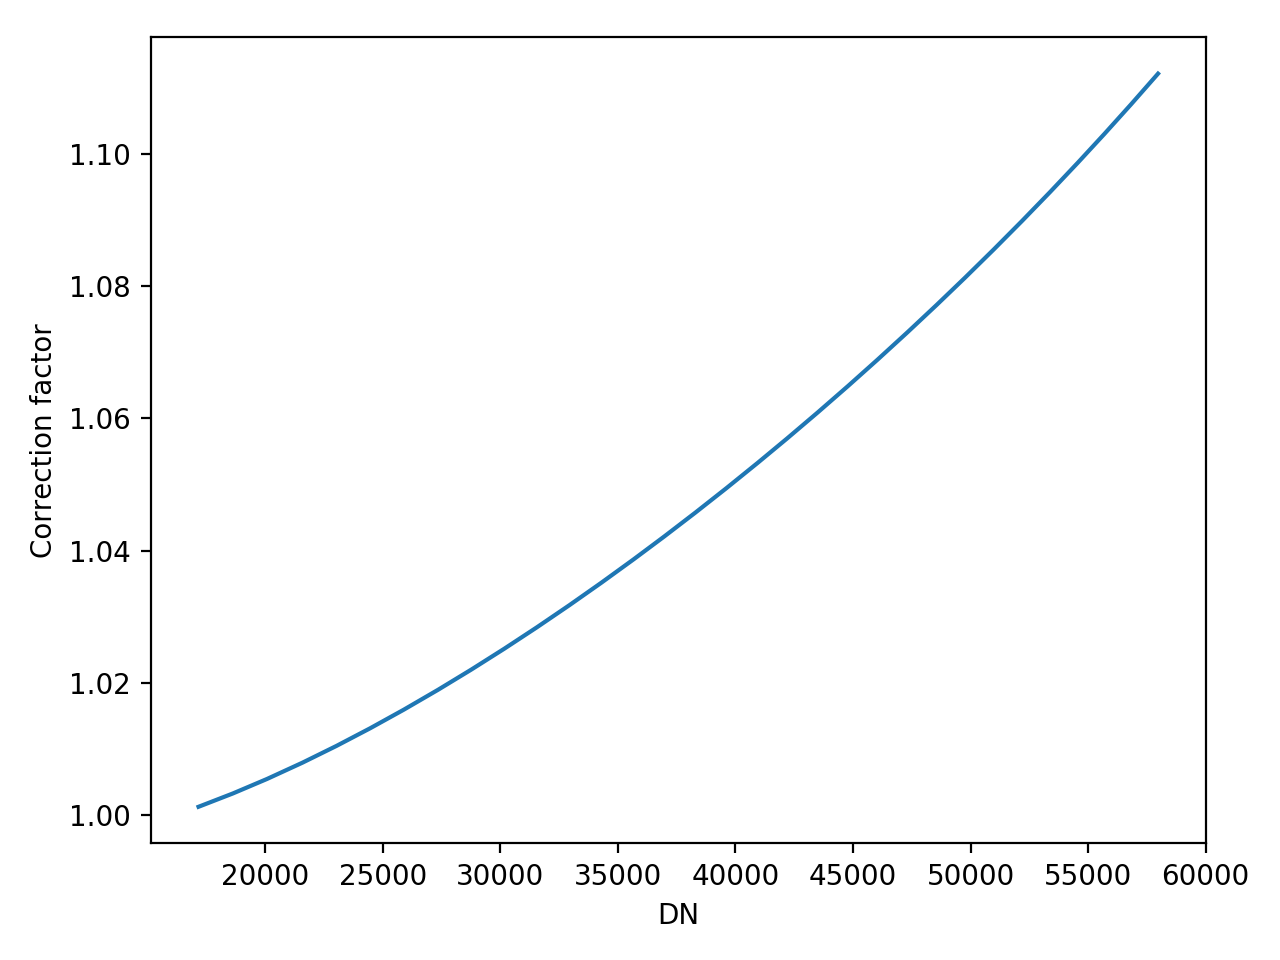

<IPython.core.display.Javascript object>


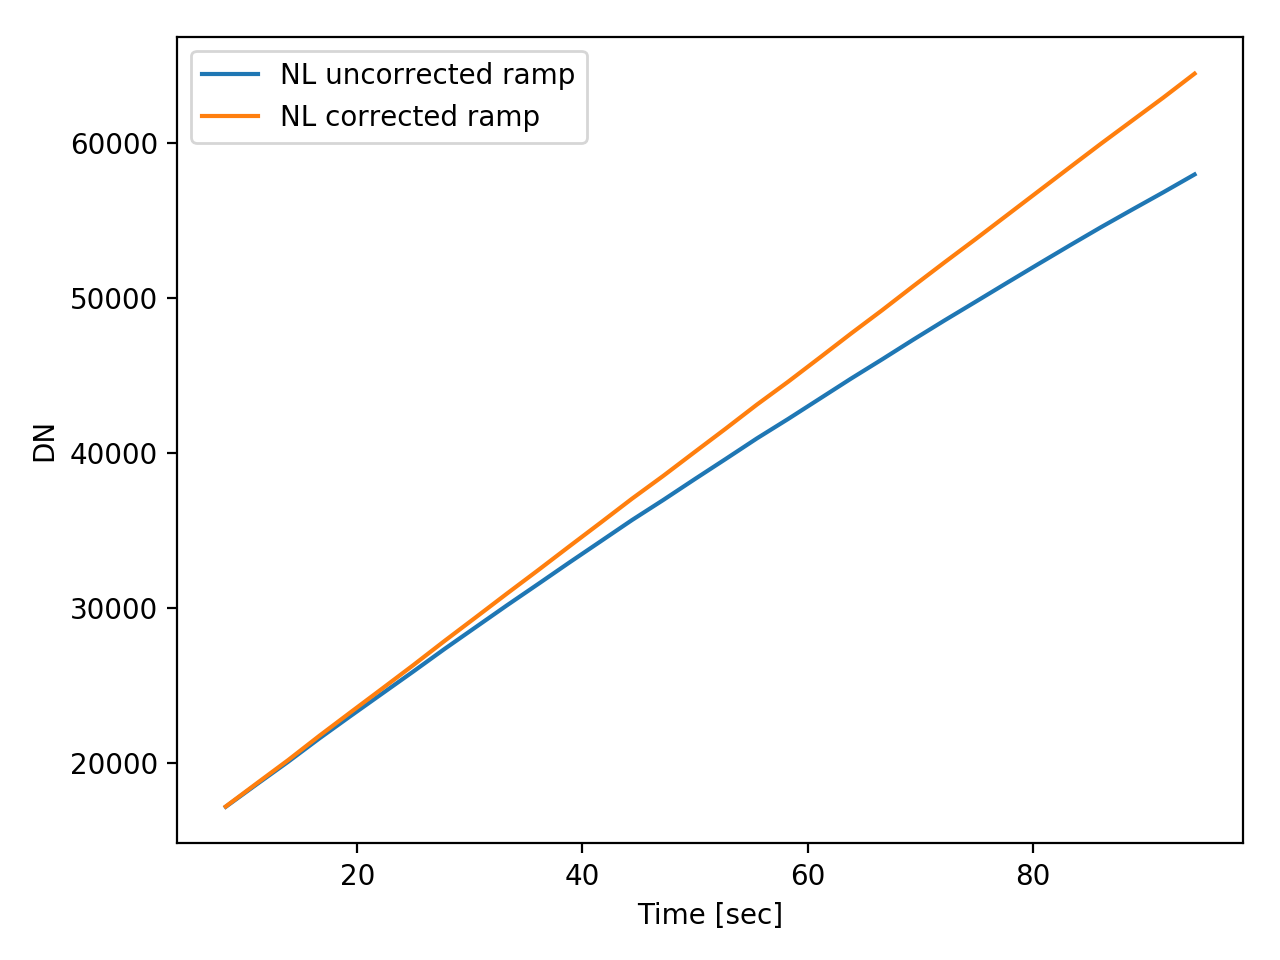

<IPython.core.display.Javascript object>


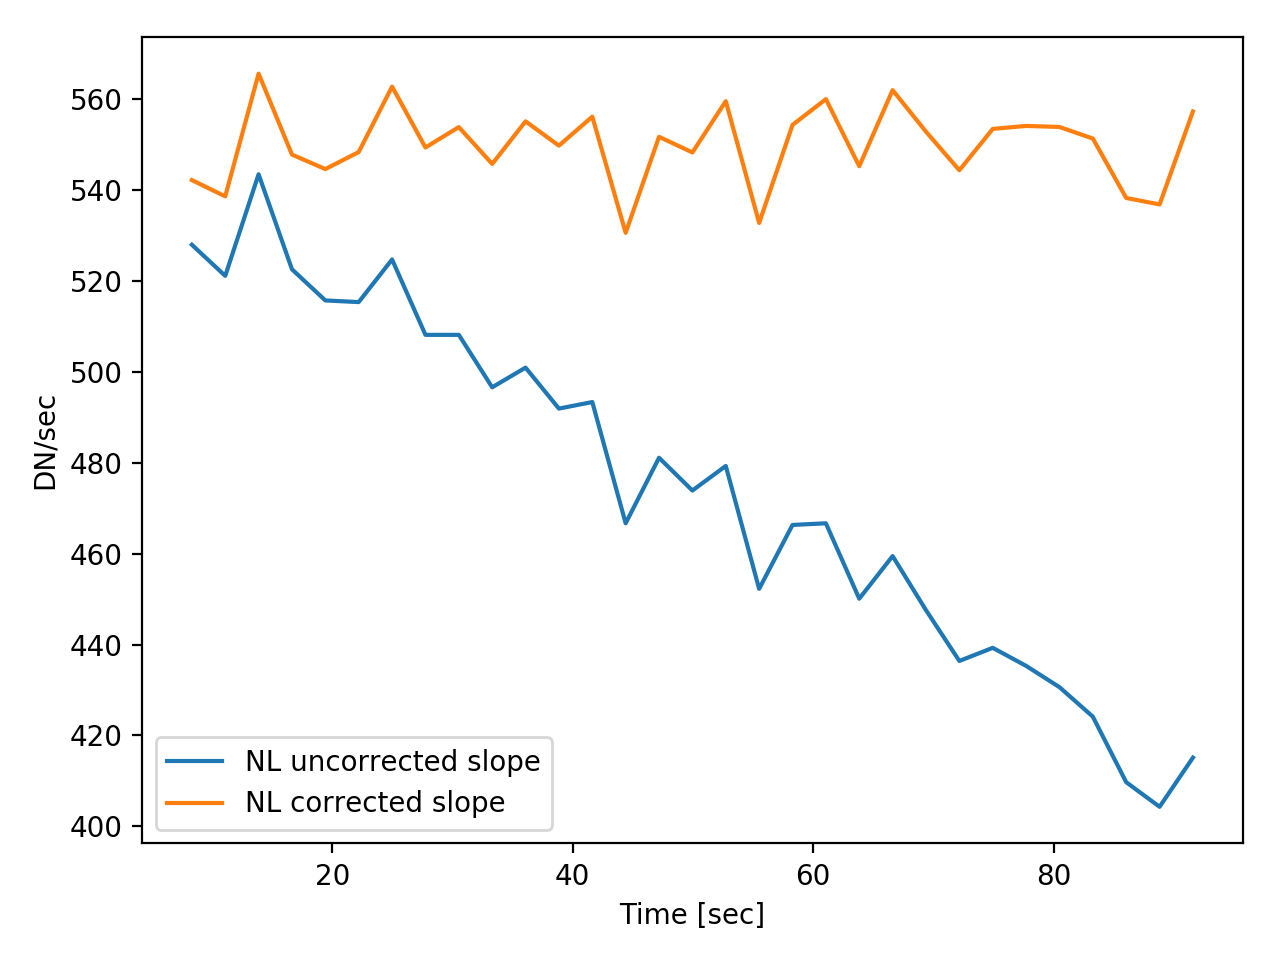

In [13]:
# for i in range(image_shape[1]):
#     for j in range(image_shape[2]):
#         new_rate[:, i, j], out_ramp[:, i, j] = correct_ramp_DN(inramp[:, i, j], out_parameters[:, i, j])

num_samples = inramp.size
cor_factor = np.polynomial.polynomial.polyval(inramp, out_parameters[:, ypos, xpos])

plt.figure()
plt.plot(inramp,cor_factor)
plt.xlabel('DN')
plt.ylabel('Correction factor')
plt.tight_layout()

# correct ramp by applying derived NL correction
corrected_ramp = cor_factor * inramp

plt.figure()
plt.plot(intime,inramp,label='NL uncorrected ramp')
plt.plot(intime,corrected_ramp,label='NL corrected ramp')
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.legend()
plt.tight_layout()

new_rate_DN = np.diff(corrected_ramp)
new_rate[:, ypos, xpos] = new_rate_DN

plt.figure()
plt.plot(intime[:-1],np.diff(inramp)/frame_delta_time,label='NL uncorrected slope')
plt.plot(intime[:-1],new_rate_DN/frame_delta_time,label='NL corrected slope')
plt.xlabel('Time [sec]')
plt.ylabel('DN/sec')
plt.legend()
plt.tight_layout()

## Derive non-linearity correction for a single trace in MRS slice

In [14]:
# initialize placeholders
bias_map,linear_term_map,quad_term_map,cubic_term_map = [np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64) for i in range(4)]
out_parameters = np.zeros(shape =(order + 1, image_shape[1], image_shape[2] ), dtype=np.float64)
count_rate_at_0DN = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
for i in range(1024):
    if i%100 == 0:
        print 'Row {}'.format(i)
    ypos,xpos = trace_y[i],trace_x[i]
    time  = np.arange(nframes)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
    tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
    time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
    time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

    # derive non-linearity correction
    intime = time3
    inramp = tramp3

    num_samples = inramp.size
    first_fit_order = 3
    assert num_samples > order + 3, 'Not enough samples to derive a non-linearity correction'

    bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)

    expected_rate = linear_term
    expected_DN = expected_rate * (intime-intime[0]) + inramp[0]

    # now get the ratio between the expected DN and the actual DN. 
    # This is the correction factor.
    correction_factor = expected_DN/inramp
    assert np.sum(np.isfinite(correction_factor)) == correction_factor.size, 'There are non legal values in the correction factor array'

    #solve for the correction factor as a function of observed DN.
    coefs = np.polynomial.polynomial.polyfit(inramp, correction_factor, order)

    # insert results in placeholder array
    bias_map[ypos,xpos],linear_term_map[ypos,xpos],quad_term_map[ypos,xpos],cubic_term_map[ypos,xpos] = bias,linear_term,quad_term,cubic_term
    out_parameters[:, ypos,xpos] = coefs
    count_rate_at_0DN[ypos,xpos] = expected_rate

Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


In [ ]:
sigma_smooth = 15
fig,axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].plot(bias_map[trace_y,trace_x])
axs[0,0].plot(gaussian_filter1d(bias_map[trace_y,trace_x],sigma_smooth))
axs[0,0].set_ylabel('DN')
axs[0,0].set_title('Bias')
axs[0,1].plot(linear_term_map[trace_y,trace_x])
axs[0,1].plot(gaussian_filter1d(linear_term_map[trace_y,trace_x],sigma_smooth))
axs[0,1].set_ylabel('DN/sec')
axs[0,1].set_title('Linear term')
axs[1,0].plot(quad_term_map[trace_y,trace_x])
axs[1,0].plot(gaussian_filter1d(quad_term_map[trace_y,trace_x],sigma_smooth))
axs[1,0].set_ylabel(r'DN/sec$^2$')
axs[1,0].set_title('Quadratic term')
axs[1,1].plot(cubic_term_map[trace_y,trace_x])
axs[1,1].plot(gaussian_filter1d(cubic_term_map[trace_y,trace_x],sigma_smooth))
axs[1,1].set_ylabel(r'DN/sec$^3$')
axs[1,1].set_title('Cubic term')
for i,j in itertools.product(range(2),range(2)):
    axs[i,j].set_xlabel(r'Y-pixel')
plt.tight_layout()

In [23]:
# fit straight lines to the coefficients
first_order_fit_bias = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[0,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
first_order_fit_linear = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[1,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
first_order_fit_quad = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[2,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
first_order_fit_cubic = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[3,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
first_order_fit_fourth = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[4,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])

<IPython.core.display.Javascript object>


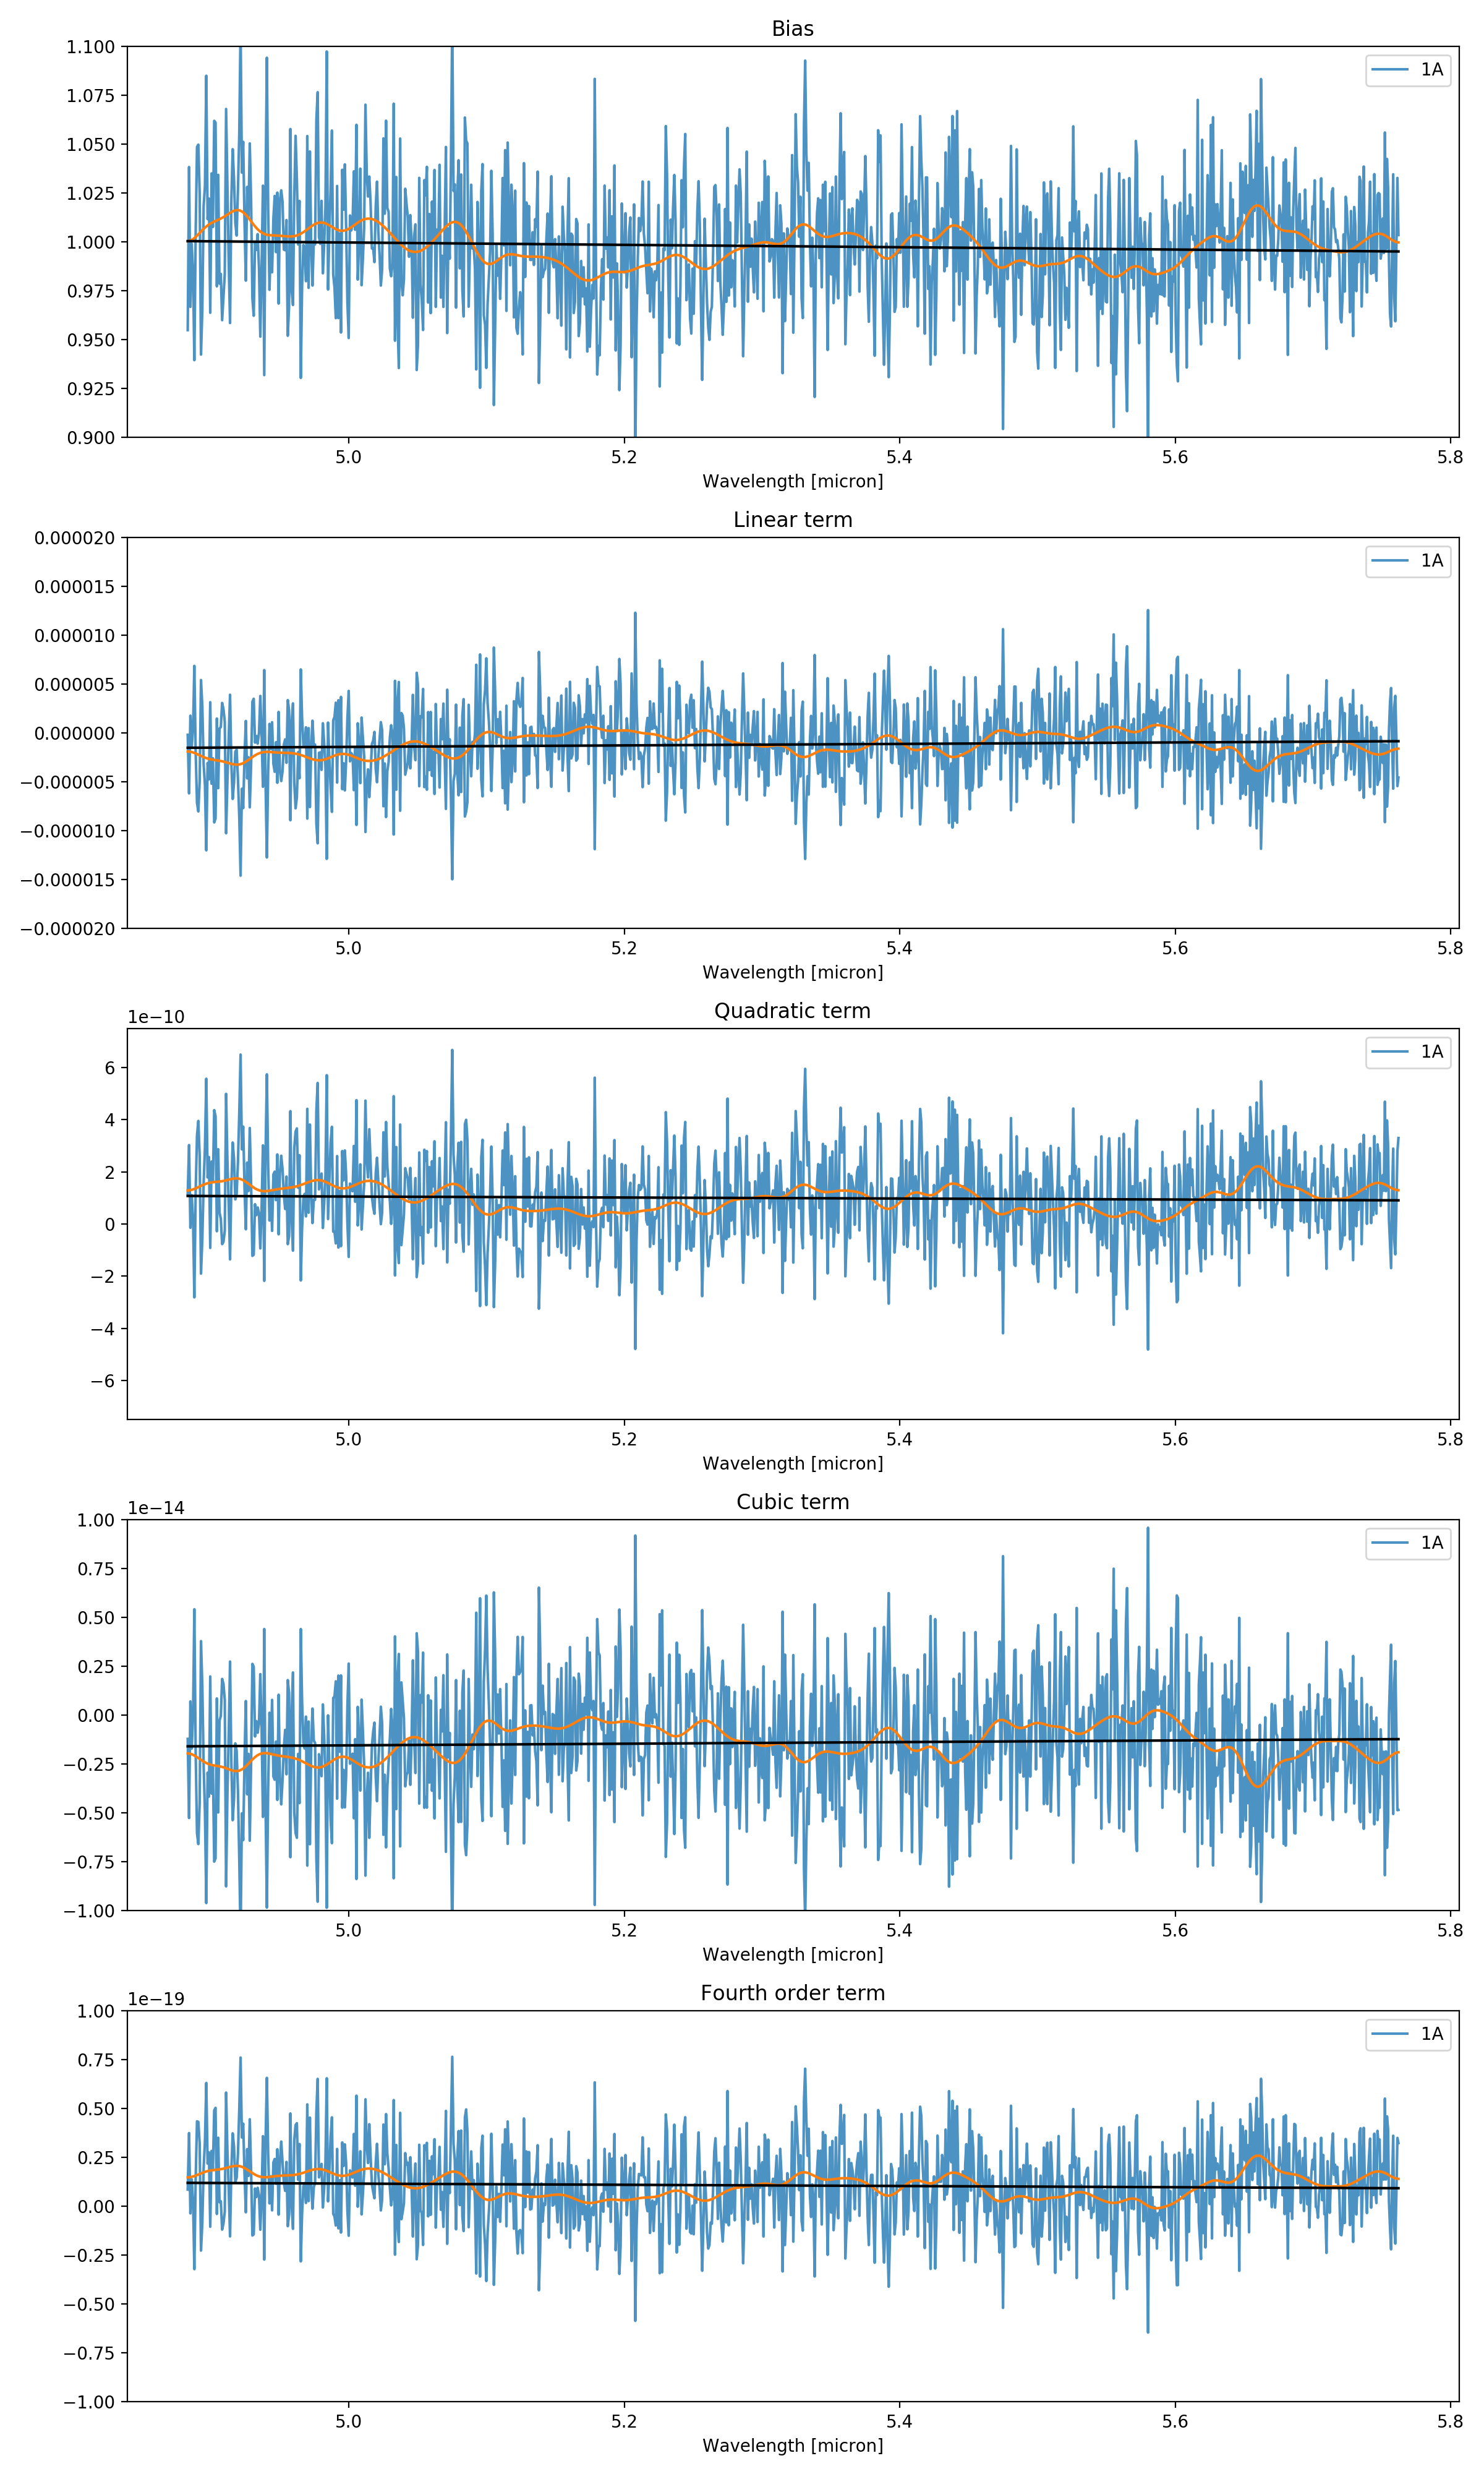

In [30]:
plt.close('all')
sigma_smooth = 10
fig,axs = plt.subplots(5,1,figsize=(12,20))
axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[0,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters[0,trace_y,trace_x],sigma_smooth),zorder=0)
axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_bias,'k',zorder=0)
axs[0].set_ylim(0.9,1.1)
# axs[0].hlines(1,4.5,19,'r',linestyle='dashed',zorder=1)
#     axs[0].hlines(np.mean(out_parameters_dic[band][0,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
axs[0].set_title('Bias')
axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[1,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters[1,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[1].hlines(np.mean(out_parameters_dic[band][1,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
# axs[1].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_linear,'k',zorder=0)
axs[1].set_ylim(-0.00002,0.00002)
axs[1].set_title('Linear term')
axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[2,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters[2,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[2].hlines(np.mean(out_parameters_dic[band][2,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
# axs[2].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_quad,'k',zorder=0)
axs[2].set_ylim(-0.75*10**-9,0.75*10**-9)
axs[2].set_title('Quadratic term')
axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[3,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters[3,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[3].hlines(np.mean(out_parameters_dic[band][3,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
# axs[3].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_cubic,'k',zorder=0)
axs[3].set_ylim(-1e-14,1e-14)
axs[3].set_title('Cubic term')
axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters[4,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters[4,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[4].hlines(np.mean(out_parameters_dic[band][4,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
# axs[4].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_fourth,'k',zorder=0)
axs[4].set_ylim(-1*10**-19,1*10**-19)
axs[4].set_title('Fourth order term')
for plot in range(5):
    axs[plot].set_xlabel(r'Wavelength [micron]')
    axs[plot].legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


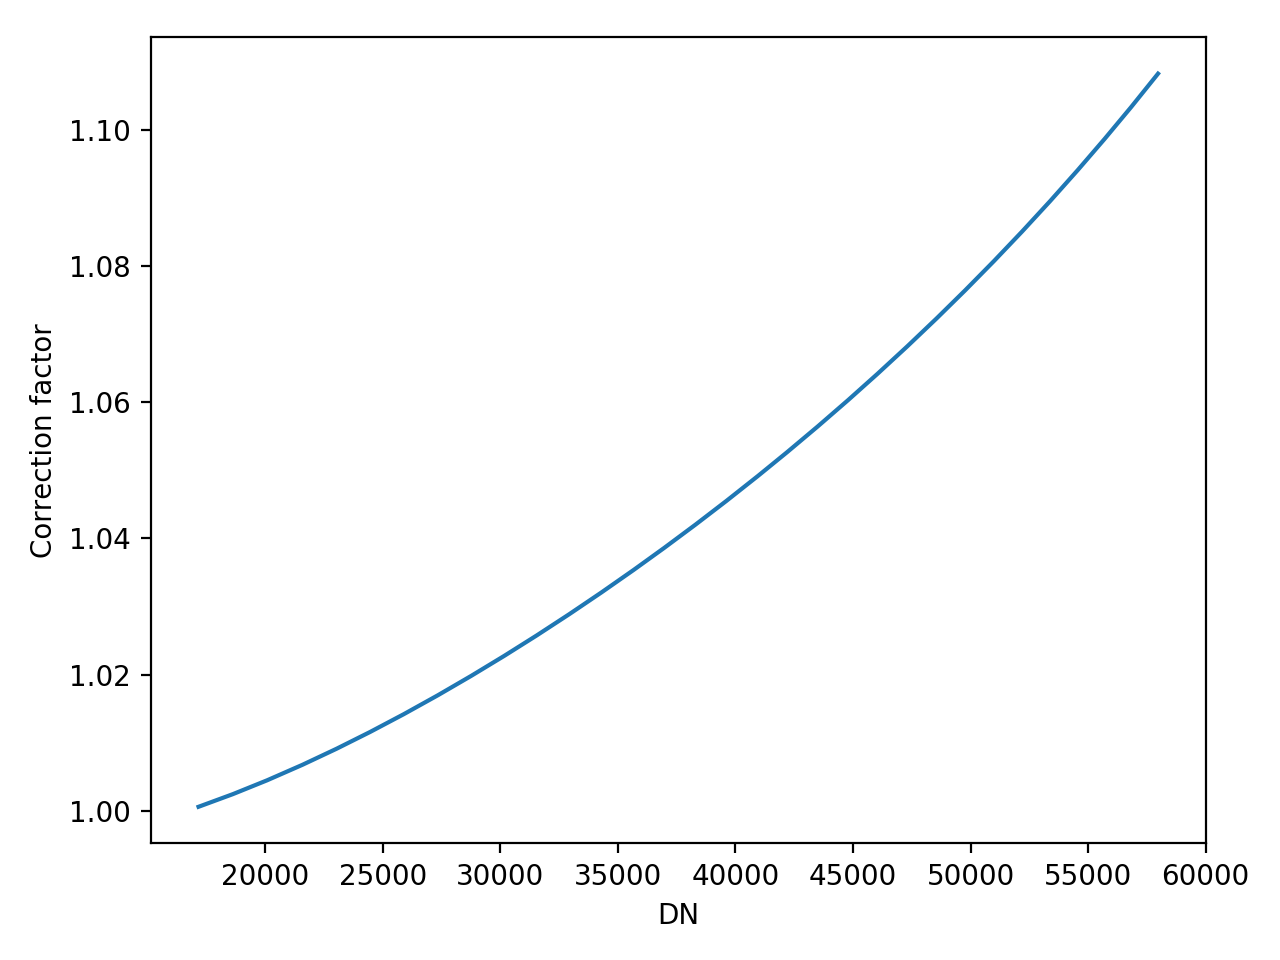

<IPython.core.display.Javascript object>


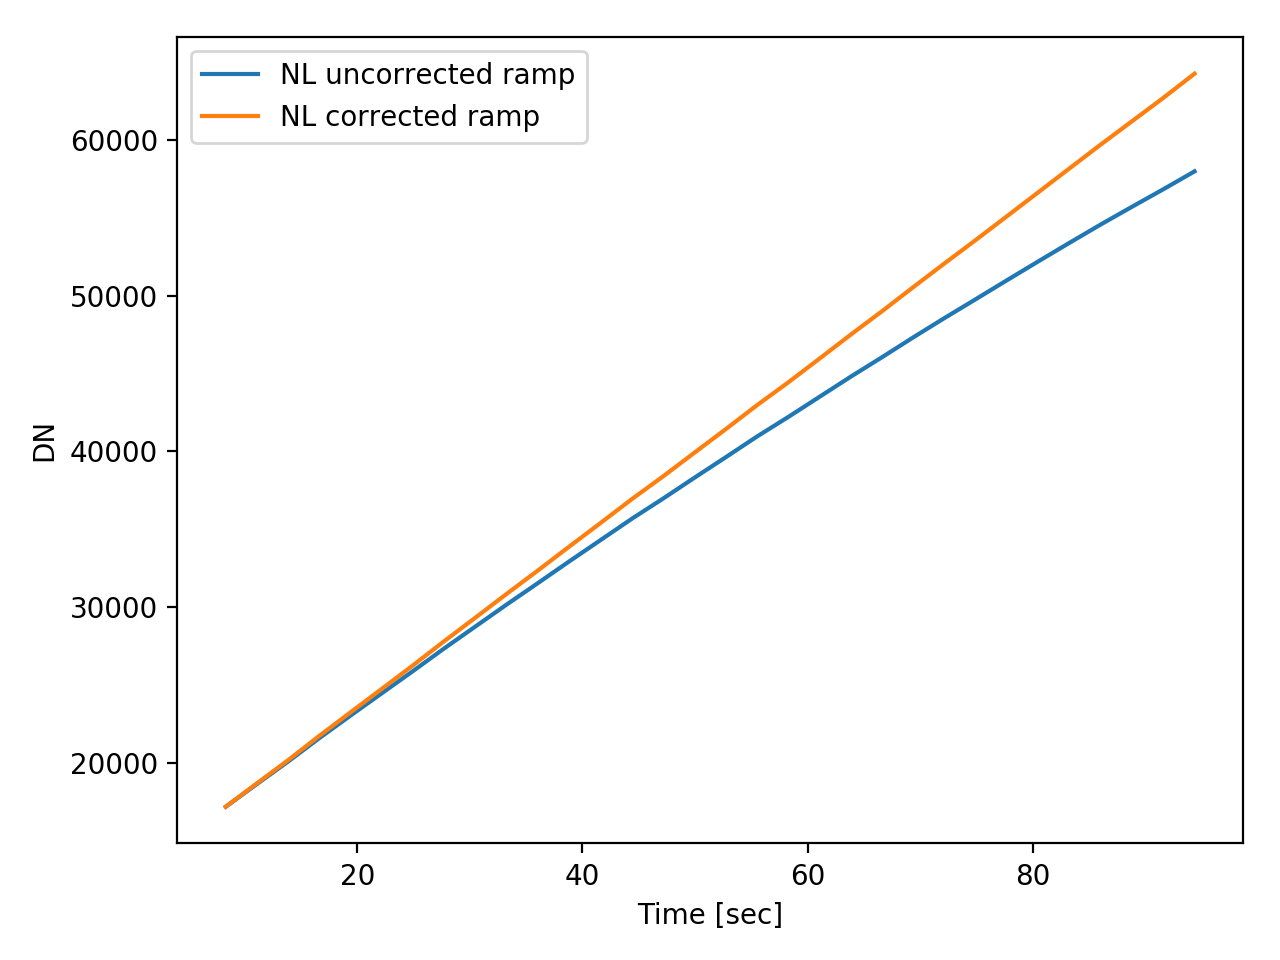

<IPython.core.display.Javascript object>


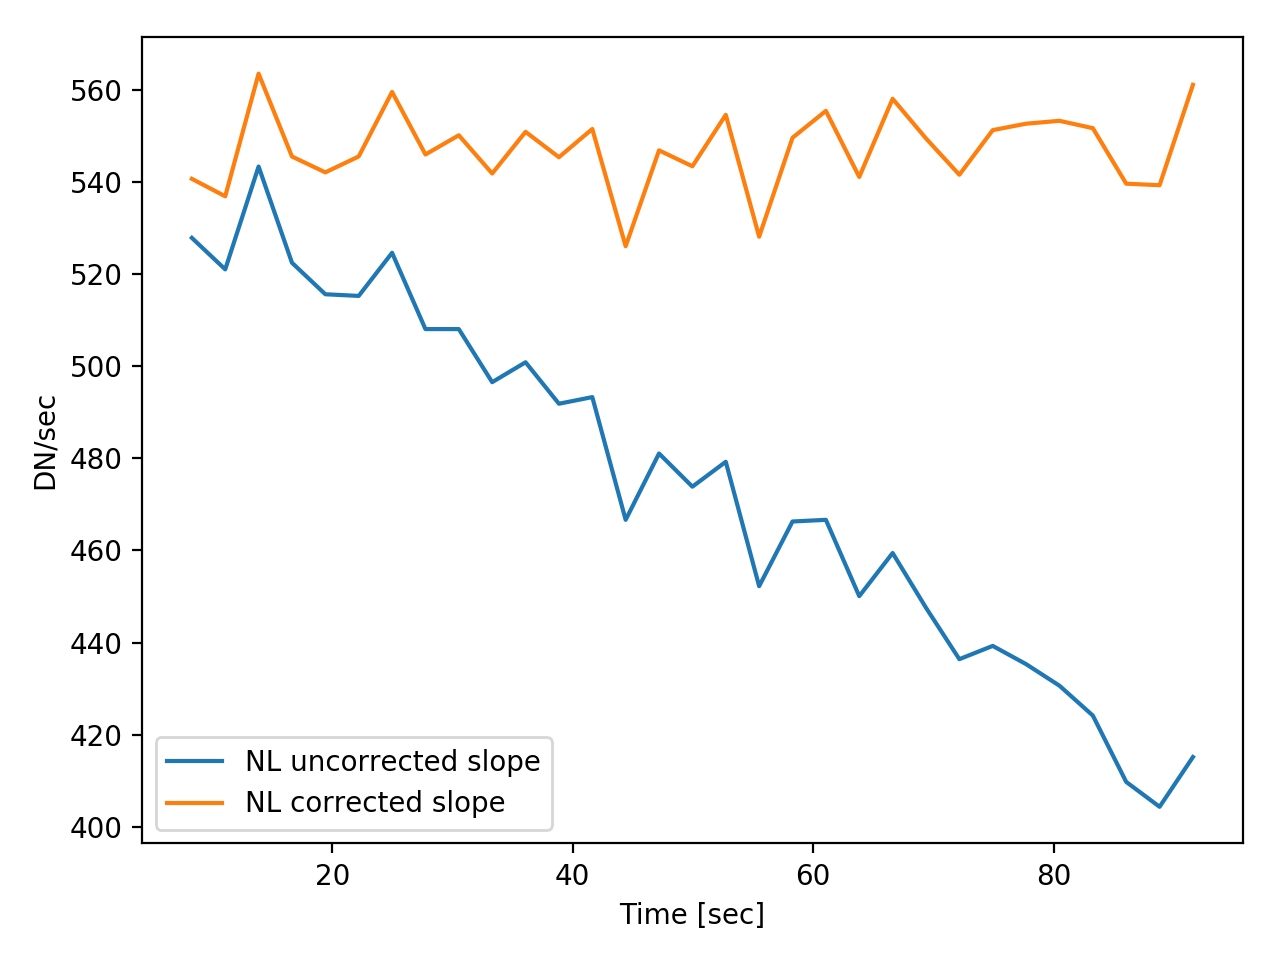

In [35]:
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
ypos,xpos = trace_y[512],trace_x[512]

time  = np.arange(nframes)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

intime = time3
inramp = tramp3

num_samples = inramp.size
cor_factor = np.polynomial.polynomial.polyval(inramp, [first_order_fit_bias[ypos],first_order_fit_linear[ypos],first_order_fit_quad[ypos],first_order_fit_cubic[ypos],first_order_fit_fourth[ypos]])

plt.figure()
plt.plot(inramp,cor_factor)
plt.xlabel('DN')
plt.ylabel('Correction factor')
plt.tight_layout()

# correct ramp by applying derived NL correction
corrected_ramp = cor_factor * inramp

plt.figure()
plt.plot(intime,inramp,label='NL uncorrected ramp')
plt.plot(intime,corrected_ramp,label='NL corrected ramp')
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.legend()
plt.tight_layout()

new_rate_DN = np.diff(corrected_ramp)
new_rate[:, ypos, xpos] = new_rate_DN

plt.figure()
plt.plot(intime[:-1],np.diff(inramp)/frame_delta_time,label='NL uncorrected slope')
plt.plot(intime[:-1],new_rate_DN/frame_delta_time,label='NL corrected slope')
plt.xlabel('Time [sec]')
plt.ylabel('DN/sec')
plt.legend()
plt.tight_layout()

# Multi-band analysis

In [16]:
out_parameters_dic = {}

for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
#     # CV3 MIRM33541
#     if band in ['1A','2A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits'
#     elif band in ['1B','2B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_495_SE_2016-01-19T10h33m18.fits'
#     elif band in ['1C','2C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_495_SE_2016-01-19T11h07m48.fits'
#     elif band in ['3A','4A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_494_SE_2016-01-19T09h59m18.fits'
#     elif band in ['3B','4B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_494_SE_2016-01-19T10h33m19.fits'
#     elif band in ['3C','4C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_494_SE_2016-01-19T11h07m48.fits'
    # CV3 MIRM108 (ramps purposed for non-linearity correction)
    if band in ['1A','2A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits'
    elif band in ['1B','2B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_494_SE_2016-01-21T20h36m13.fits'
    elif band in ['1C','2C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_495_SE_2016-01-21T21h49m12.fits'
    elif band in ['3A','4A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_494_SE_2016-01-21T21h49m12.fits'
    elif band in ['3B','4B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_495_SE_2016-01-21T22h32m32.fits'
    elif band in ['3C','4C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_494_SE_2016-01-21T22h32m32.fits'
    image_hdu = fits.open(filename)
    image_data = fits.getdata(filename)[:,:1024,:]

    #
    image_shape = image_data.shape
    nints       = image_hdu[0].header['NINT']
    ngroups     = image_hdu[0].header['NGROUP']
    nframes     = image_shape[0]
    frame_delta_time = image_hdu[0].header['TFRAME']

    # initialize placeholders
    bias_map,linear_term_map,quad_term_map,cubic_term_map = [np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64) for i in range(4)]
    out_parameters = np.zeros(shape =(order + 1, image_shape[1], image_shape[2] ), dtype=np.float64)

    d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    for i in range(1024):
        ypos,xpos = trace_y[i],trace_x[i]
        time  = np.arange(nframes)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
        tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

        # derive non-linearity correction
        intime = time3
        inramp = tramp3

        num_samples = inramp.size
        first_fit_order = 3
        if num_samples <= order + 3:
            continue

        bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)

        expected_rate = linear_term
        expected_DN = expected_rate * (intime-intime[0]) + inramp[0]

        # now get the ratio between the expected DN and the actual DN. 
        # This is the correction factor.
        correction_factor = expected_DN/inramp
        assert np.sum(np.isfinite(correction_factor)) == correction_factor.size, 'There are non legal values in the correction factor array'

        #solve for the correction factor as a function of observed DN.
        coefs = np.polynomial.polynomial.polyfit(inramp, correction_factor, order)

        # insert results in placeholder array
        bias_map[ypos,xpos],linear_term_map[ypos,xpos],quad_term_map[ypos,xpos],cubic_term_map[ypos,xpos] = bias,linear_term,quad_term,cubic_term
        out_parameters[:, ypos,xpos] = coefs

    out_parameters_dic[band] = out_parameters

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


<IPython.core.display.Javascript object>


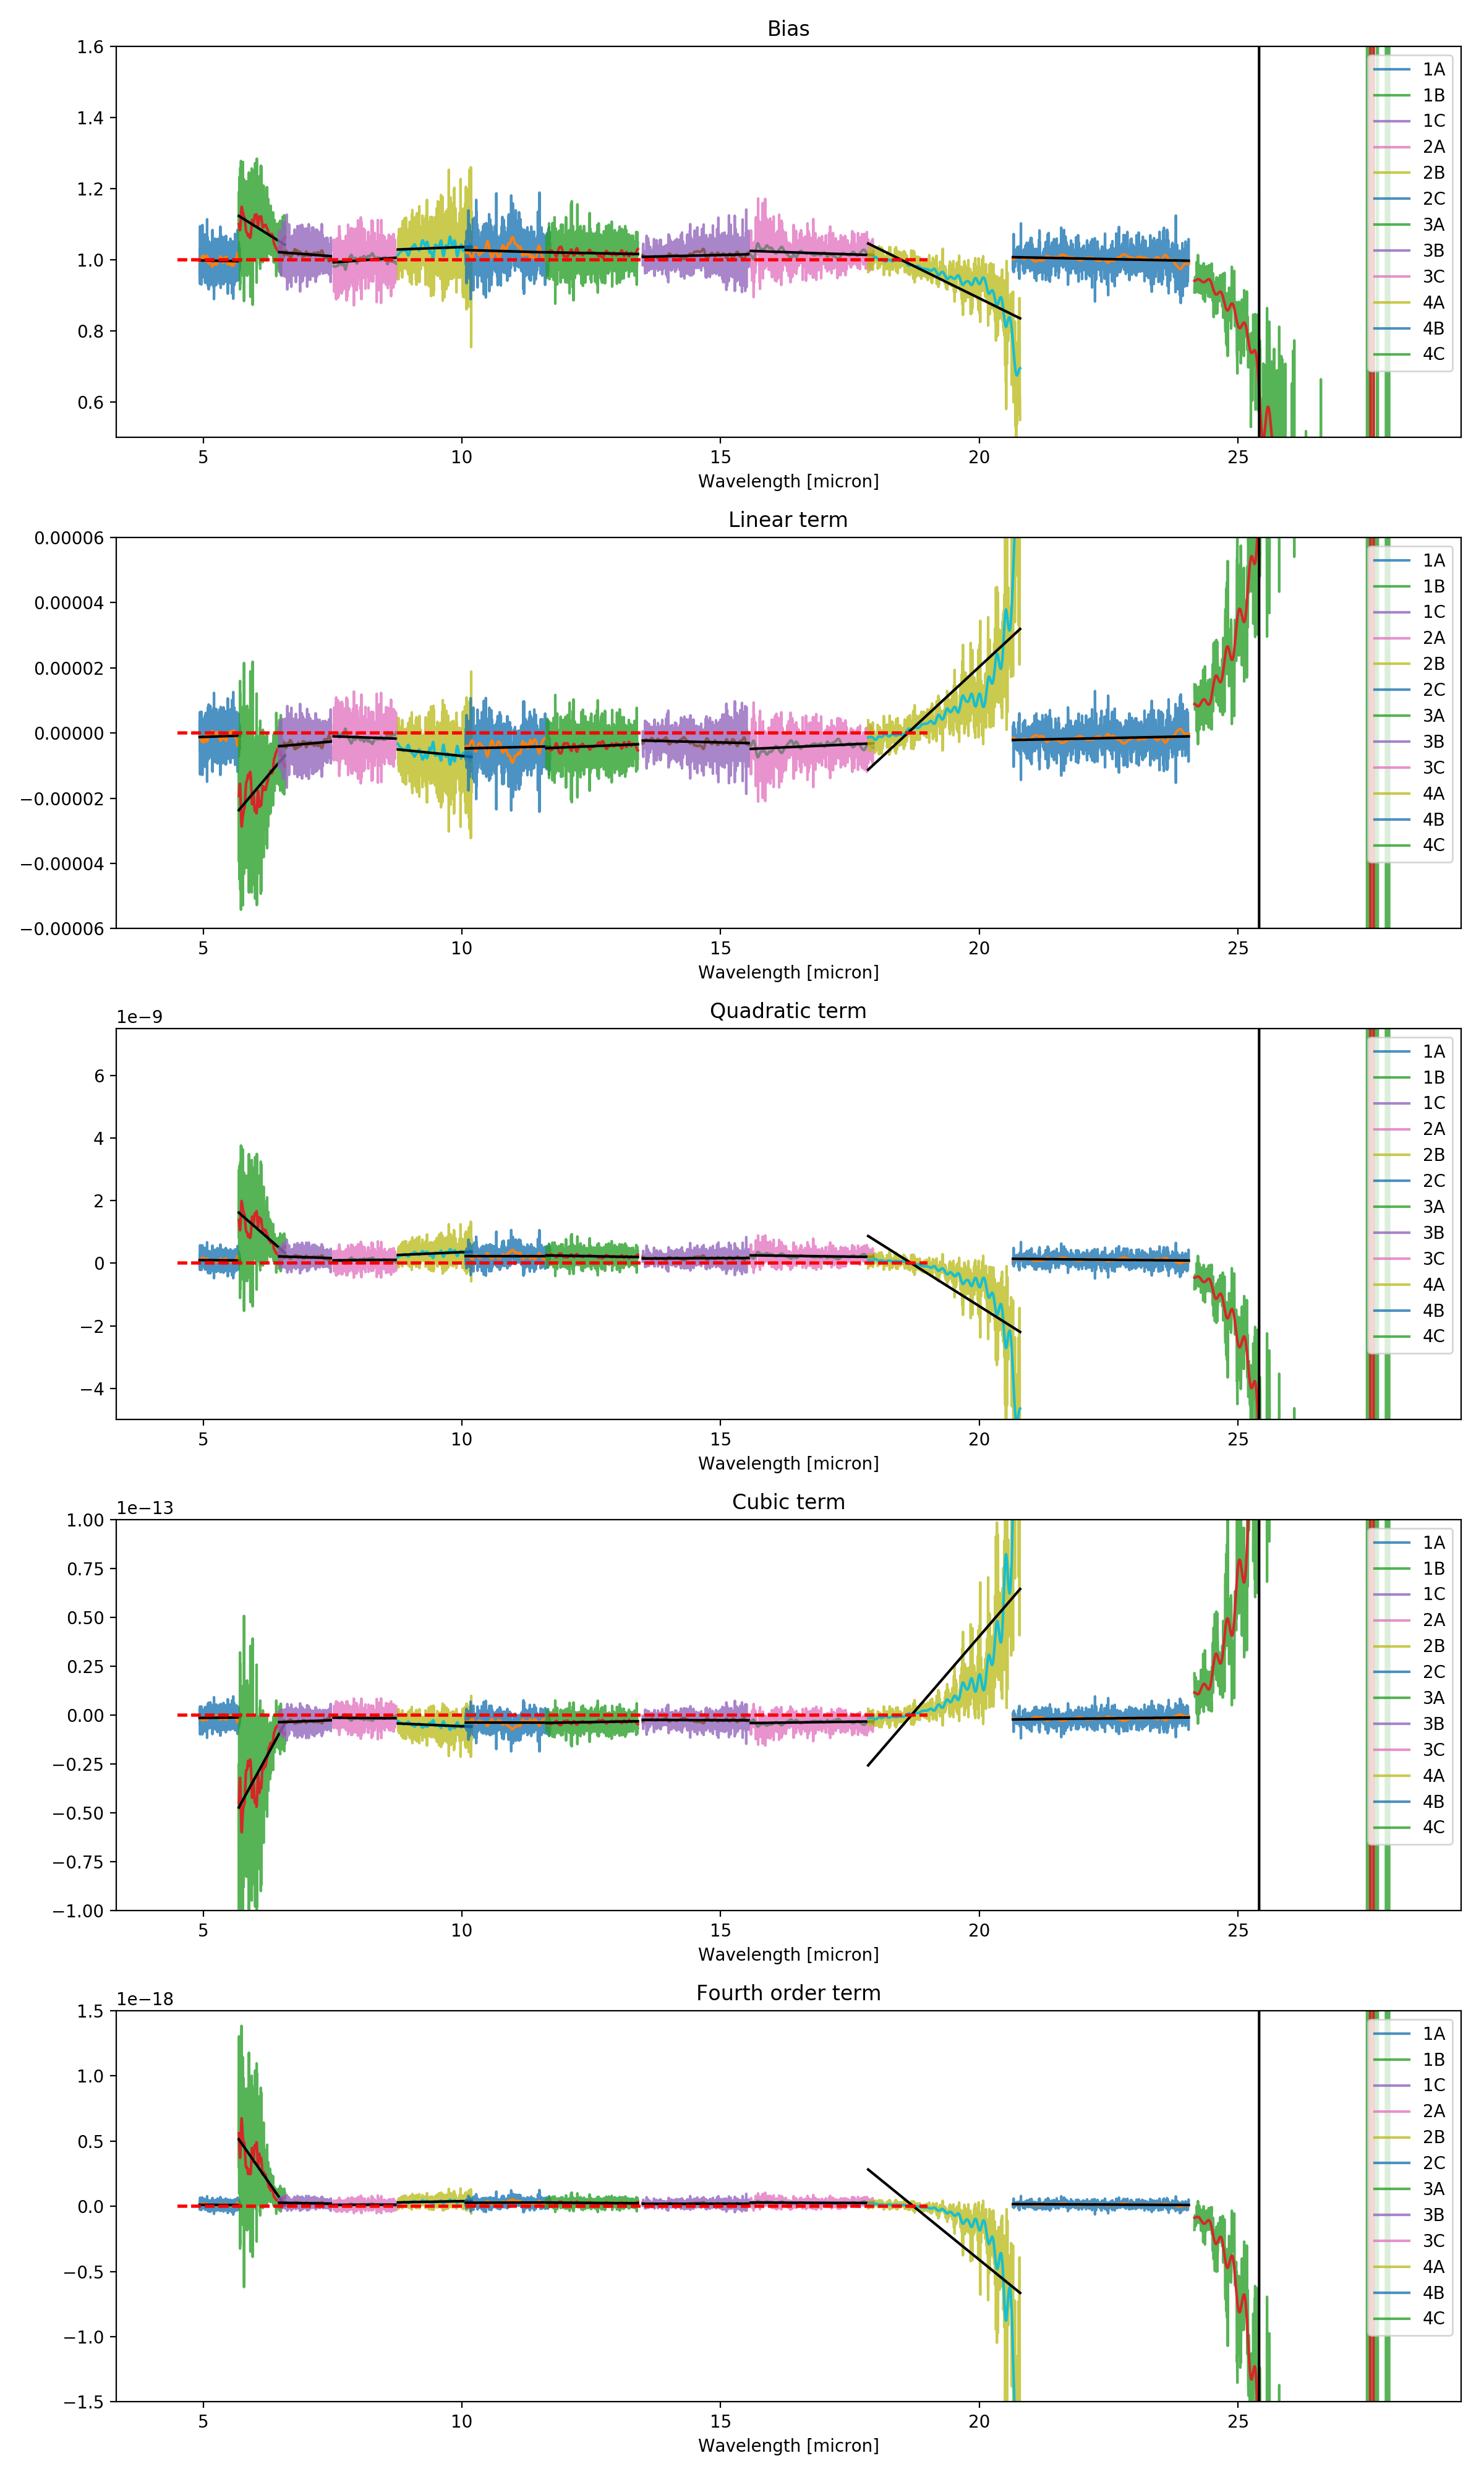

In [29]:
plt.close('all')
# Use band 1A values as reference
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format('1A'),path=d2cMapDir)
trace_y_1A,trace_x_1A = funcs.detpixel_trace('1A',d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

fig,axs = plt.subplots(5,1,figsize=(12,20))
bands = ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']
for i,band in enumerate(bands):
    xaxis   = i*len(np.arange(1024)[50:950])+np.arange(1024)[50:950]
    d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    
    trace_y,trace_x = trace_y[50:950],trace_x[50:950]
    
    first_order_fit_bias = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][0,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
    first_order_fit_linear = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][1,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
    first_order_fit_quad = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][2,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
    first_order_fit_cubic = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][3,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
    first_order_fit_fourth = np.poly1d(np.polyfit(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][4,trace_y,trace_x],1))(d2cMaps['lambdaMap'][trace_y,trace_x])
    
    sigma_smooth = 10
    axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][0,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
    axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters_dic[band][0,trace_y,trace_x],sigma_smooth),zorder=0)
    axs[0].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_bias,'k',zorder=0)
    axs[0].set_ylim(0.5,1.6)
    axs[0].hlines(1,4.5,19,'r',linestyle='dashed',zorder=1)
#     axs[0].hlines(np.mean(out_parameters_dic[band][0,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
    axs[0].set_title('Bias')
    axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][1,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
    axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters_dic[band][1,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[1].hlines(np.mean(out_parameters_dic[band][1,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
    axs[1].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
    axs[1].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_linear,'k',zorder=0)
    axs[1].set_ylim(-0.00006,0.00006)
    axs[1].set_title('Linear term')
    axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][2,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
    axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters_dic[band][2,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[2].hlines(np.mean(out_parameters_dic[band][2,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
    axs[2].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
    axs[2].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_quad,'k',zorder=0)
    axs[2].set_ylim(-0.5*10**-8,0.75*10**-8)
    axs[2].set_title('Quadratic term')
    axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][3,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
    axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters_dic[band][3,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[3].hlines(np.mean(out_parameters_dic[band][3,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
    axs[3].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
    axs[3].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_cubic,'k',zorder=0)
    axs[3].set_ylim(-1e-13,1e-13)
    axs[3].set_title('Cubic term')
    axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],out_parameters_dic[band][4,trace_y,trace_x],alpha=0.8,zorder=0,label=band)
    axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],gaussian_filter1d(out_parameters_dic[band][4,trace_y,trace_x],sigma_smooth),zorder=0)
#     axs[4].hlines(np.mean(out_parameters_dic[band][4,trace_y,trace_x]),xaxis[0],xaxis[-1],'k',linestyle='dashed',zorder=1)
    axs[4].hlines(0,4.5,19,'r',linestyle='dashed',zorder=1)
    axs[4].plot(d2cMaps['lambdaMap'][trace_y,trace_x],first_order_fit_fourth,'k',zorder=0)
    axs[4].set_ylim(-1.5*10**-18,1.5*10**-18)
    axs[4].set_title('Fourth order term')
for plot in range(5):
    axs[plot].set_xlabel(r'Wavelength [micron]')
    axs[plot].legend()
plt.tight_layout()

## Remarks:
* The noise profile seems to be larger in channel 1 compared to channel 2 or 3. That is a direct effect of the response of the instrument being higher in the shorter wavelengths and lower in the longer wavelengths of each band respectively. As a result the signal (in DN/sec) is higher towards at the shorter wavelengths and lower at the longer wavelengths of each band.
* In the case of the CV3 internal calibration source measurements MIRM33541, the blackbody temperature is so that the absolute signal level is lower in band 1A, compared to band 1B, then band 1C, etc. This means that the standard deviation of the non-linearity coefficients at the shorter wavelengths of band 1A is larger than that in band 1B, 1C, 2A, etc.

In [22]:
VBIAS_dic = {}

for band in ['1A','1B','1C','3A','3B','3C']:
    print 'Band {}'.format(band)
#     # CV3 MIRM33541
#     if band in ['1A','2A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits'
#     elif band in ['1B','2B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_495_SE_2016-01-19T10h33m18.fits'
#     elif band in ['1C','2C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_495_SE_2016-01-19T11h07m48.fits'
#     elif band in ['3A','4A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_494_SE_2016-01-19T09h59m18.fits'
#     elif band in ['3B','4B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_494_SE_2016-01-19T10h33m19.fits'
#     elif band in ['3C','4C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_494_SE_2016-01-19T11h07m48.fits'
    # CV3 MIRM108 (ramps purposed for non-linearity correction)
    if band in ['1A','2A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits'
    elif band in ['1B','2B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_494_SE_2016-01-21T20h36m13.fits'
    elif band in ['1C','2C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_495_SE_2016-01-21T21h49m12.fits'
    elif band in ['3A','4A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_494_SE_2016-01-21T21h49m12.fits'
    elif band in ['3B','4B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_495_SE_2016-01-21T22h32m32.fits'
    elif band in ['3C','4C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_494_SE_2016-01-21T22h32m32.fits'
    image_hdu = fits.open(filename)
    
    VDDUC,VDETCOM = [],[]
    for i in range(len(image_hdu[1].data)):
        if image_hdu[1].data[i][1] in ['IGDP_MIR_SW_V_VDDUC','IGDP_MIR_LW_V_VDDUC']:
            VDDUC.append(float(image_hdu[1].data[i][2]))
        elif image_hdu[1].data[i][1] in ['IGDP_MIR_SW_V_VDETCOM','IGDP_MIR_LW_V_VDETCOM']:
            VDETCOM.append(float(image_hdu[1].data[i][2]))
    VDDUC,VDETCOM = np.array(VDDUC),np.array(VDETCOM)

    VBIAS = (VDDUC+0.2)-VDETCOM
    VBIAS_dic[band] = VBIAS
# both detector halves have same bias voltage
VBIAS_dic['2A'] = VBIAS_dic['1A']
VBIAS_dic['2B'] = VBIAS_dic['1B']
VBIAS_dic['2C'] = VBIAS_dic['1C']
VBIAS_dic['4A'] = VBIAS_dic['3A']
VBIAS_dic['4B'] = VBIAS_dic['3B']
VBIAS_dic['4C'] = VBIAS_dic['3C']

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A


<IPython.core.display.Javascript object>


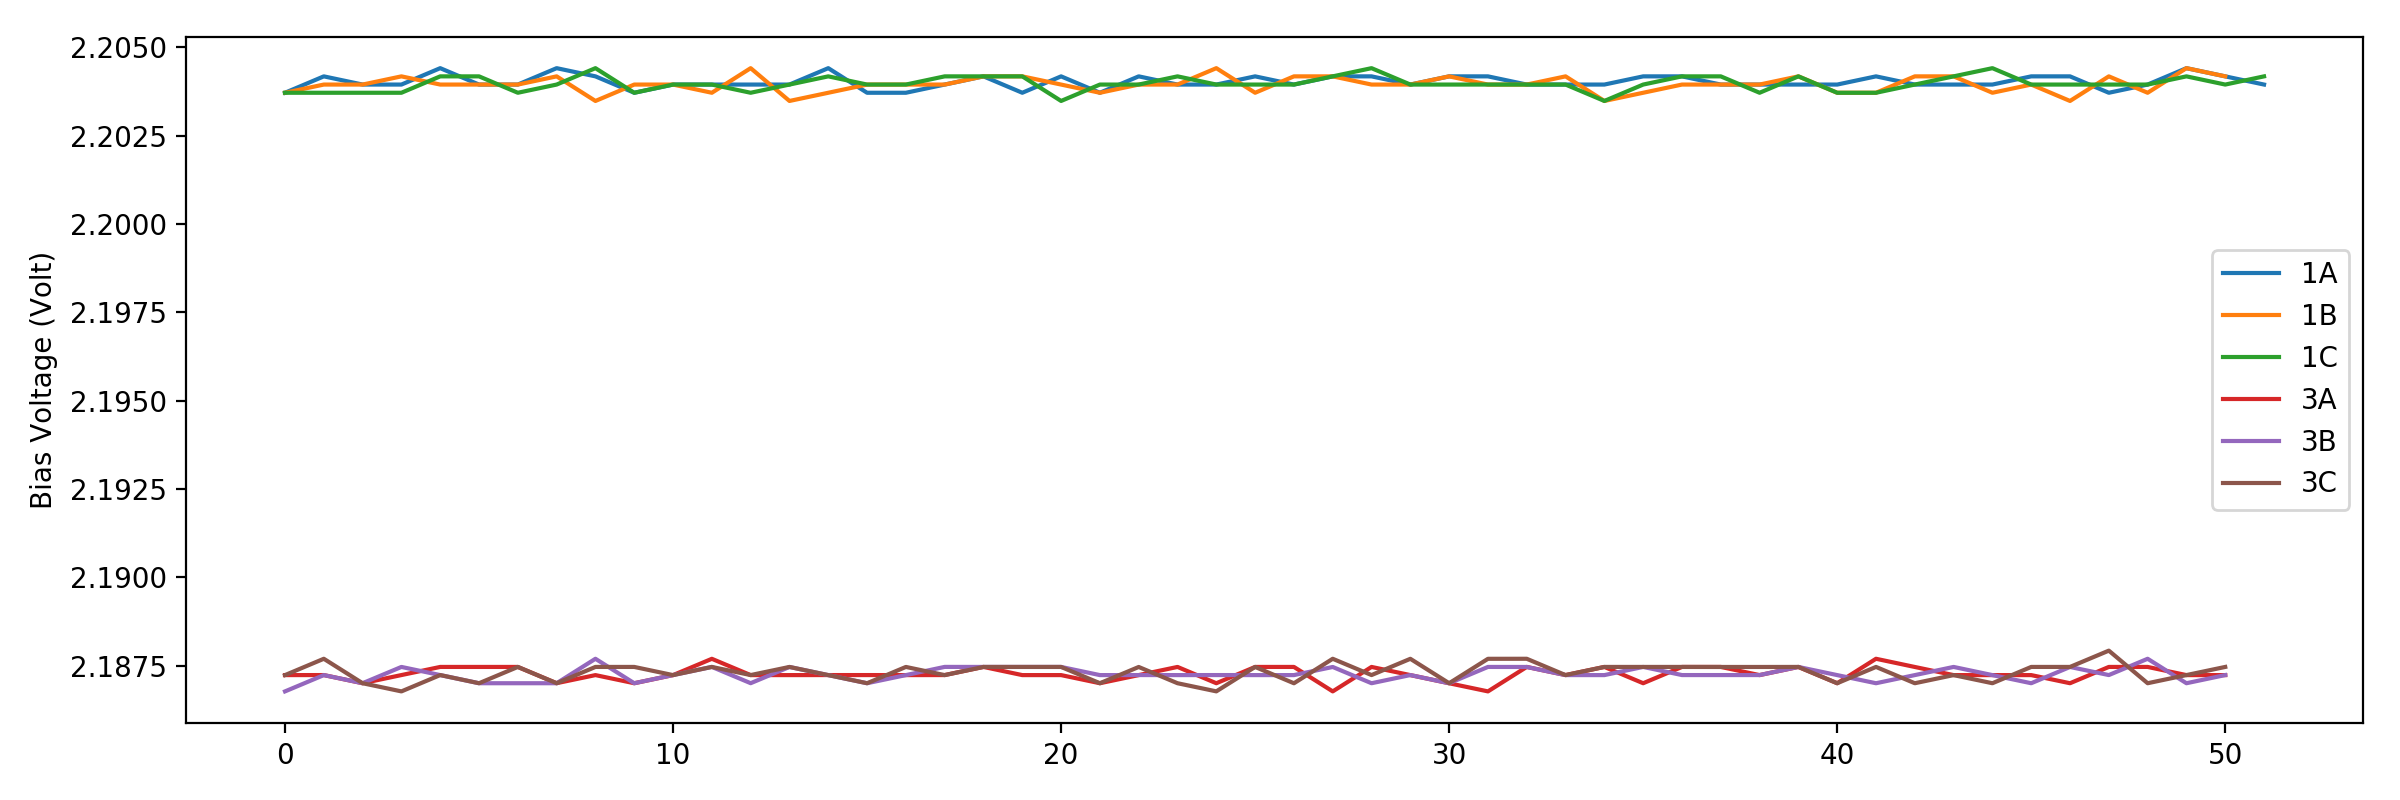

In [25]:
plt.figure(figsize=(12,4))
for band in ['1A','1B','1C','3A','3B','3C']:
    plt.plot(np.arange(len(VBIAS_dic[band])),VBIAS_dic[band],label=band)
plt.ylabel('Bias Voltage (Volt)')
plt.legend()
plt.tight_layout()

In [21]:
# compute median of normalized rates
normalized_rateDN = new_rate/count_rate_at_0DN
print normalized_rateDN.shape
normalized_rate = normalized_rateDN[:-1,:,:]
print normalized_rate.shape

saturation_level = 58000
norm_shape = normalized_rate[:-1,:,:].shape
med_normalized_rate = np.zeros(norm_shape[0], dtype=np.float64)
out_cube = np.zeros_like(normalized_rate)
for i in range(norm_shape[0]):
    normalized_plane = normalized_rate[i,:,:]
    normalized_plane[image_data[i,:,:] > 58000] = np.nan
    normalized_plane[count_rate_at_0DN < 600] = np.nan
    if np.sum(np.isfinite(normalized_plane)) > 10000:
        med_normalized_rate[i] = np.median(normalized_plane[np.isfinite(normalized_plane)])
# return med_normalized_rate[med_normalized_rate > 0]
# med_norm_rate_DN = find_med_normalized_rate(normalized_rateDN[:-1,:,:], calimage,countrateat0DN_DN)

(15, 1024, 1032)
(14, 1024, 1032)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


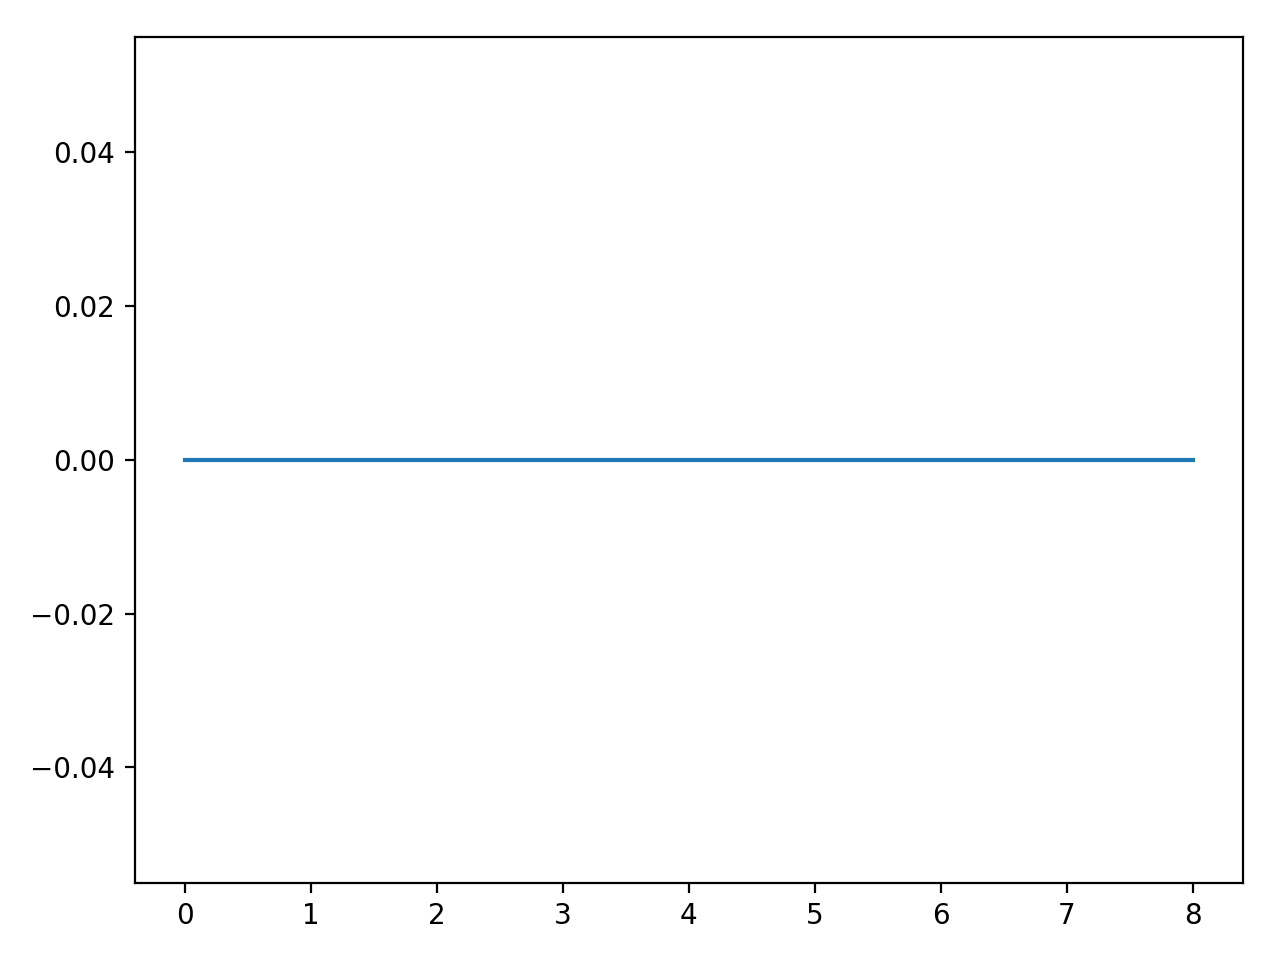

In [23]:
plt.figure()
plt.plot(med_normalized_rate[4:])
np.std(med_normalized_rate[4:])
plt.tight_layout()

<h2>Now try to correct the 2nd integration using the cal parameters from the 1st integration</h2>

In [13]:
correct_image1=fits.getdata('M105_00_000.fits')

In [15]:
cor_ramp_DN, cor_rate_DN = applynlimage(correct_image1, correct_ramp_DN ,outsolutionDN)

finished row  0
finished row  50
finished row  100
finished row  150
finished row  200
finished row  250
finished row  300
finished row  350
finished row  400
finished row  450
finished row  500
finished row  550
finished row  600
finished row  650
finished row  700
finished row  750
finished row  800
finished row  850
finished row  900
finished row  950
finished row  1000
finished row  1050
finished row  1100
finished row  1150
finished row  1200
finished row  1250


In [16]:
hdu = fits.PrimaryHDU(cor_ramp_DN)
hdu.writeto('corrampDN.fits', overwrite=True)
hdu = fits.PrimaryHDU(cor_rate_DN)
hdu.writeto('corrateDN.fits', overwrite=True)

/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.0013456728600408855

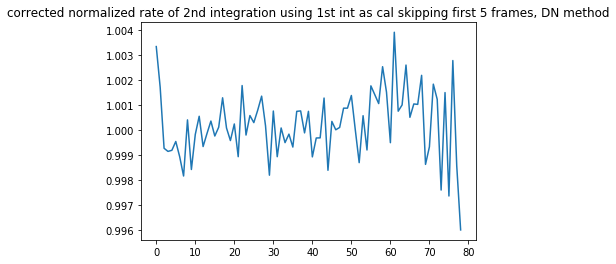

In [17]:
normalized_rate_corDN = cor_rate_DN/countrateat0DN_DN
hdu = fits.PrimaryHDU(normalized_rate_corDN)
hdu.writeto('normalizedratecorDN.fits',overwrite=True)
med_norm_rate_corDN = find_med_normalized_rate(normalized_rate_corDN[:-1,:,:], calimage,countrateat0DN_DN)
plt.plot(med_norm_rate_corDN[4:])
plt.title("corrected normalized rate of 2nd integration using 1st int as cal skipping first 5 frames, DN method")
np.std(med_norm_rate_corDN[4:])